# Optimization de paramètres ARIMA pour Tronox 2020

In [4]:
# %load ./_Snippets/finance_import_block.py
# Uncomment lorsque qu'une nouvelle ligne s'ajoute

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from yahoofinancials import YahooFinancials

import warnings
warnings.filterwarnings('ignore')

# Print automatiquement toutes les variables de la cellule (pas juste la dernière)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #"last_expr" pour rétablir par défaut

%config InlineBackend.figure_format ='retina'

# Package maison
from FinForecast import ArimaForecast as af
from FinForecast import InvestStrat


In [14]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode

In [6]:
TROX = pd.read_csv('_Input/TROX_0114-0720.csv', parse_dates= True)
TROX.index = pd.to_datetime(TROX.Date)
TROX = TROX.drop(columns= ['Date'])

In [7]:
trox_2019= TROX.loc['06-2018':'12-2019']

In [11]:
trox_2019_rtn5 = trox_2019['Adj Close'].pct_change(5)*100
trox_2019_rtn5.dropna(inplace= True)

Date
2018-06-08    3.958207
2018-06-11    5.797093
2018-06-12    5.447669
2018-06-13    6.866981
2018-06-14    4.667407
                ...   
2019-12-24    4.298240
2019-12-26    3.571431
2019-12-27   -2.382977
2019-12-30   -2.245242
2019-12-31   -2.725718
Name: Adj Close, Length: 394, dtype: float64

In [12]:
# Transform to stationary x - rolling mean deviation
trox_2019_rtn5_stdev, df_ravg_t = af.tfrm_to_MinusMean(trox_2019_rtn5)

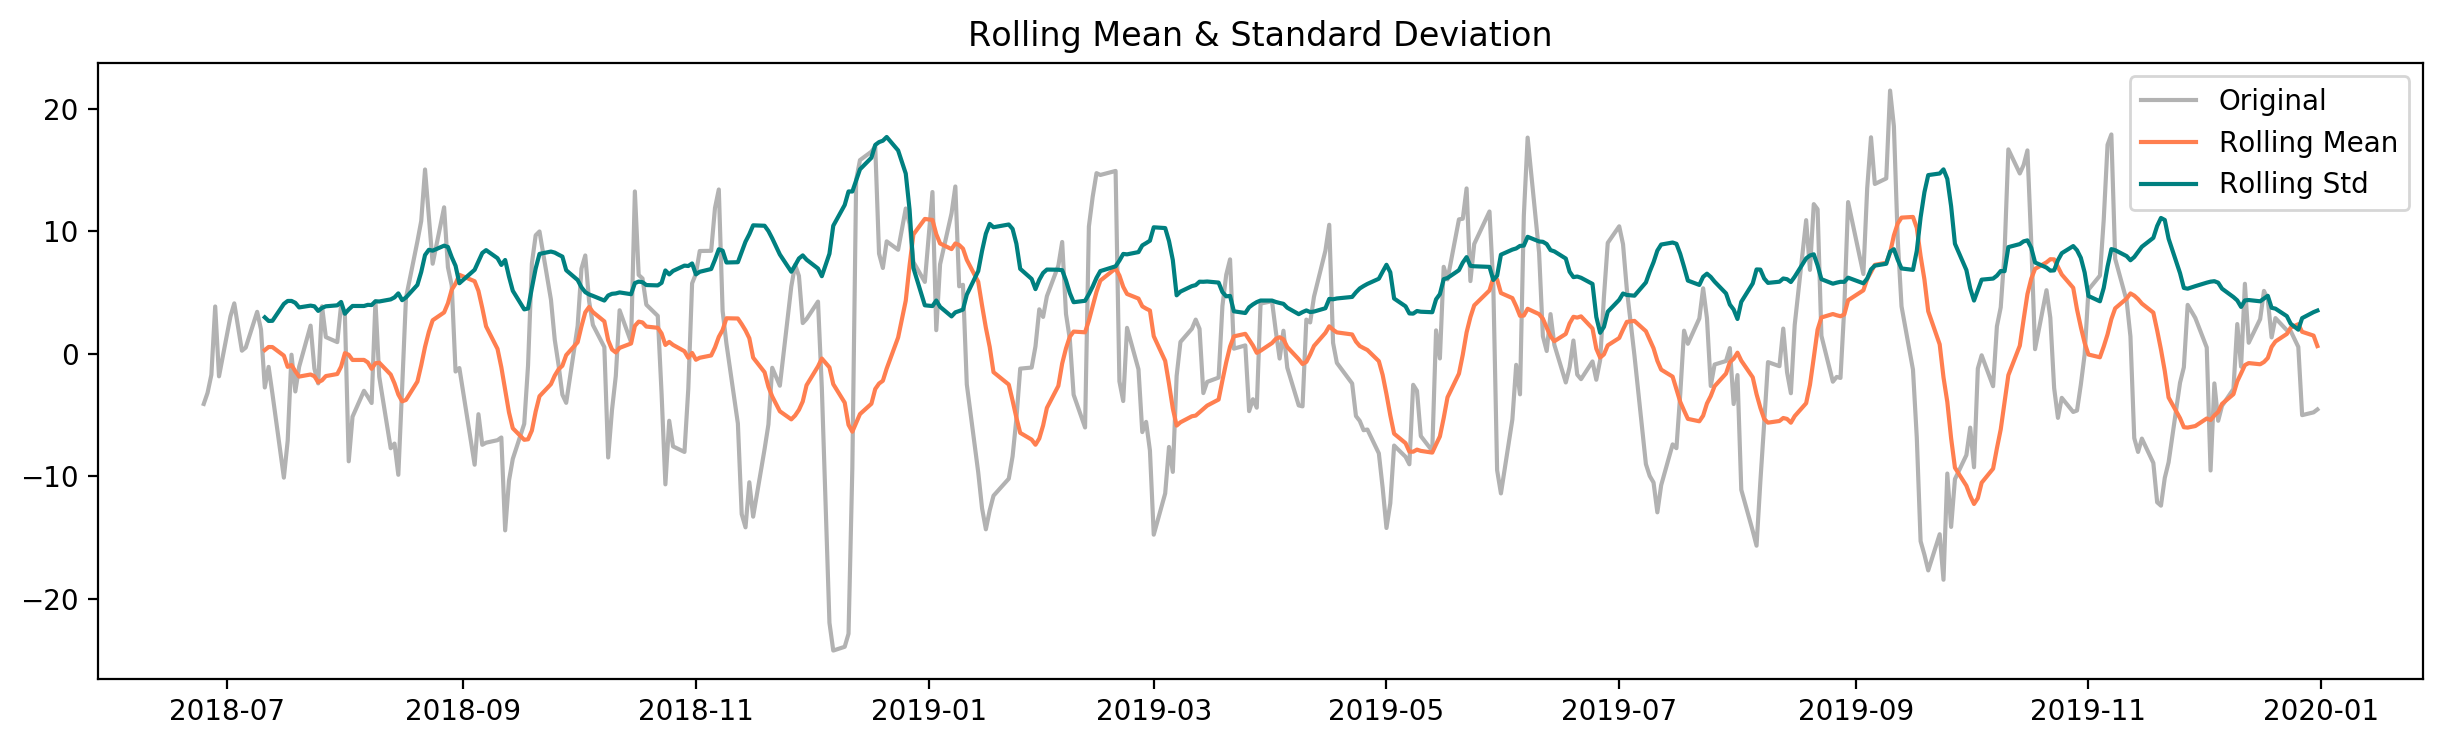

Mean MinMax Delta: 23.434167050601516
Std MinMax Delta: 15.985247722590474
ADF Statistic: -6.901544614122428
p-value: 1.278255660828814e-09
Critical Values:
	1%: -3.4483935212959844
	5%: -2.8694912343676497
	10%: -2.571005879151811


In [13]:
# Assess transformed dataset performances
af.get_stationarity(trox_2019_rtn5_stdev)

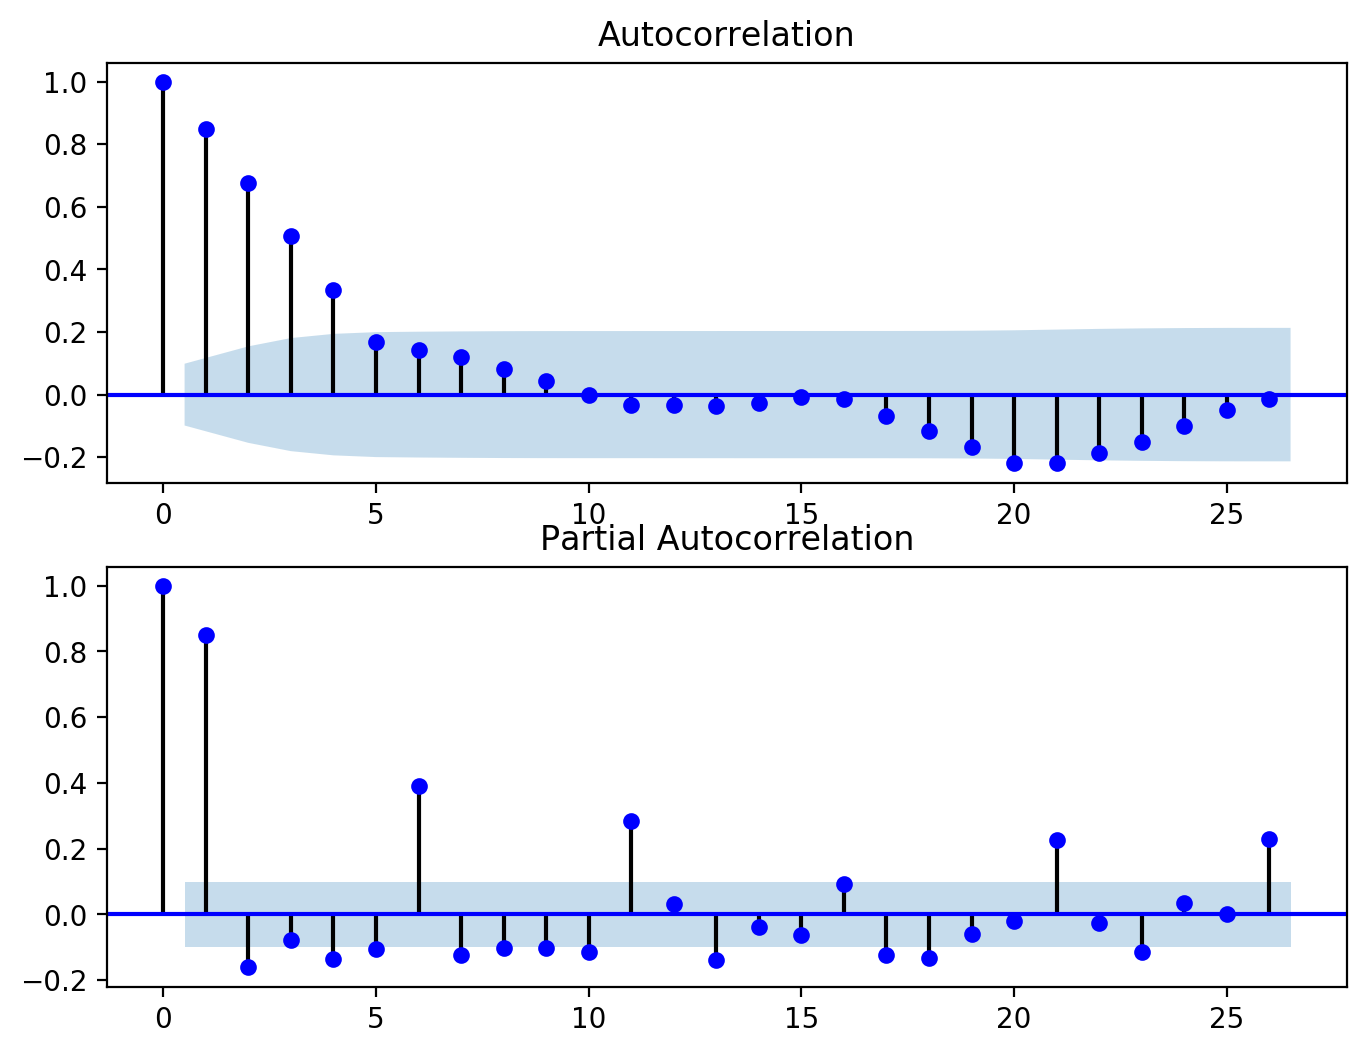

In [14]:
af.plot_corr_function(trox_2019_rtn5)
plt.show()

In [19]:
# Trouver le paramètre optimal sur une série de paramètre
aic_16_5_var = af.aic_optimize(trox_2019_rtn5_stdev, ar_max_range= 16, ma_max_range= 8)

The AIC for an ARIMA(0, 0, 0) is:  2690 
The AIC for an ARIMA(0, 0, 1) is:  2435 
The AIC for an ARIMA(0, 0, 2) is:  2295 
The AIC for an ARIMA(0, 0, 3) is:  2295 
The AIC for an ARIMA(0, 0, 4) is:  2083 
The AIC for an ARIMA(0, 0, 5) is:  2085 
The AIC for an ARIMA(0, 0, 6) is:  2086 
The AIC for an ARIMA(0, 0, 7) is:  2087 
The AIC for an ARIMA(1, 0, 0) is:  2271 
The AIC for an ARIMA(1, 0, 1) is:  2259 
The AIC for an ARIMA(1, 0, 2) is:  2259 
The AIC for an ARIMA(1, 0, 3) is:  2221 
The AIC for an ARIMA(1, 0, 4) is:  2085 
The AIC for an ARIMA(1, 0, 5) is:  2070 
The AIC for an ARIMA(1, 0, 6) is:  2070 
The AIC for an ARIMA(1, 0, 7) is:  2088 
The AIC for an ARIMA(2, 0, 0) is:  2255 
The AIC for an ARIMA(2, 0, 1) is:  2227 
The AIC for an ARIMA(2, 0, 2) is:  2226 
The AIC for an ARIMA(2, 0, 3) is:  2187 
The AIC for an ARIMA(2, 0, 4) is:  2086 
The AIC for an ARIMA(2, 0, 5) is:  2070 
The AIC for an ARIMA(2, 0, 6) is:  2071 
The AIC for an ARIMA(2, 0, 7) is:  2071 
The AIC for an A

### Optimal: (2,0,5)
L'AIC optimal est à 2070.
Comme on le retrouve sur plusieurs ordre différence, on peut trancher pour des paramètres optimaux à (2,0,5) pour donner une polynomiale juste assez flexible pour attraper les détails, mais pas trop.

## Validation de performance
### Paramètres de 2019 sur data 2020 en crise

In [37]:
ticker = 'TROX'
yahoo_financials = YahooFinancials(ticker)

data = yahoo_financials.get_historical_price_data(start_date='2020-01-01', 
                                                  end_date='2020-08-25', 
                                                  time_interval='daily')

# Extraire 'price' keys du dict vers un df
trox_2020 = pd.DataFrame(data[ticker]['prices'])

# Remplacer 'formatted_date' col par 'Date'
col = list(trox_2020.columns) 
col[-1] = 'Date'
trox_2020.columns = col

# Set index to 'Date'
trox_2020 = trox_2020.drop('date', axis=1).set_index('Date')

trox_2020['rtn5'] = trox_2020['adjclose'].pct_change(5)*100
trox_2020['rtn5_stdev'], trox_2020_ravg = af.tfrm_to_MinusMean(trox_2020['rtn5'])
col_drop = list(trox_2020.columns[:4])
trox_2020.drop(columns= col_drop, inplace= True)

trox_2020.dropna(inplace=True)
trox_2020.head()

,volume,adjclose,rtn5,rtn5_stdev
Date,,,,
2020-01-27,1851900,9.284901,-11.737515,-9.213959
2020-01-28,1037100,9.265456,-6.200777,-3.198093
2020-01-29,787400,9.177953,-5.600007,-1.713216
2020-01-30,819400,9.041841,-9.268292,-3.586026
2020-01-31,1887200,8.225159,-14.717733,-6.621883


In [38]:
window_size = 85

# Get temporary df of rolling averages
df_roll_temp= af.rollwin_ARIMA(trox_2020['rtn5_stdev'], 
                               actual= 'rtn5_stdev', 
                               ARIMA_order= (2,0,5), 
                               window_size= window_size)

In [40]:
# Stiching all together
df_roll_temp['rtn5'] = trox_2020['rtn5'].iloc[window_size: :]
df_roll_temp.columns = ['rtn5_stdev', 'Pred_stdev', 'Erreur', 'rtn5']
# Selon système d'équation résolut sur papier
df_roll_temp['Pred_rtn5'] = df_roll_temp['rtn5'] - df_roll_temp['Erreur']
trox_2020_pred = df_roll_temp.copy()


# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
trox_2020_pred['Erreur_Dir'] = ((trox_2020_pred['rtn5'] < 0) 
                                      & (trox_2020_pred['Pred_rtn5'] > 0)) | ((trox_2020_pred['rtn5'] > 0) 
                                                                                    & (trox_2020_pred['Pred_rtn5'] < 0))

In [42]:
trox_2020_pred['Erreur_Dir'].value_counts(normalize=True)

False    0.854839
True     0.145161
Name: Erreur_Dir, dtype: float64

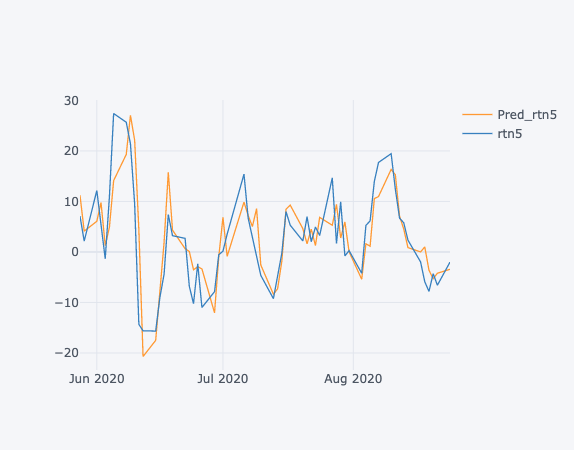

In [46]:
trox_2020_pred[['Pred_rtn5', 'rtn5']].iplot()

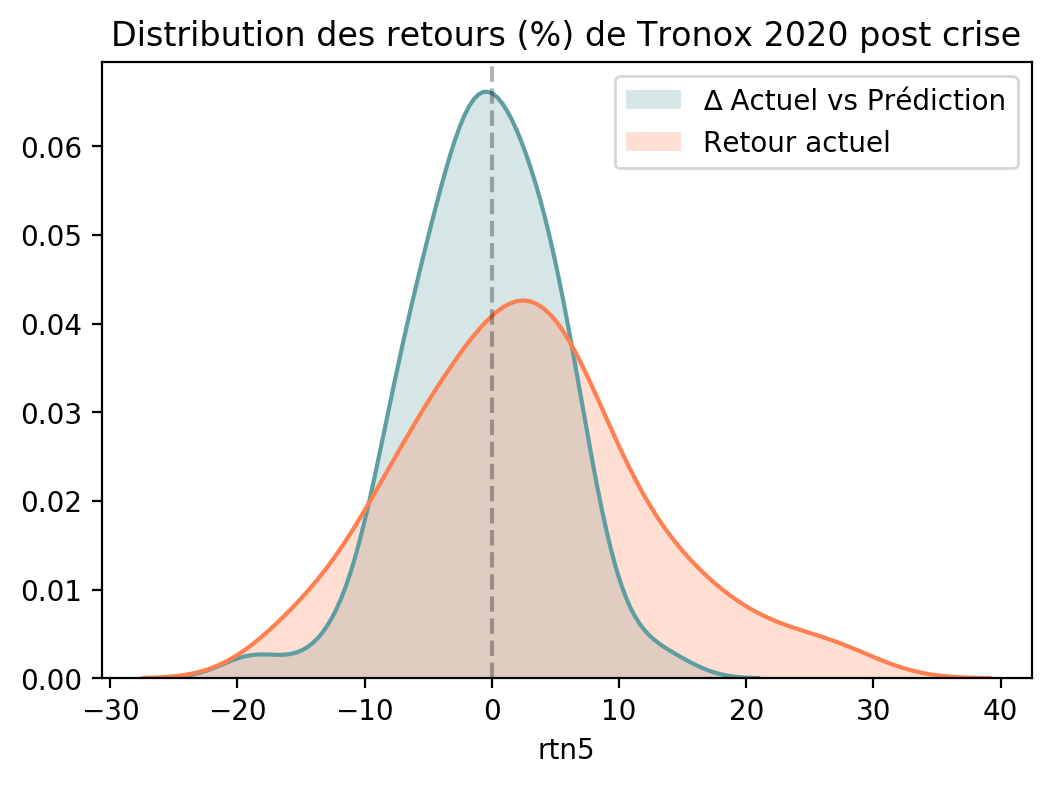

In [51]:
_= fig= plt.figure(figsize= (6, 4))
_= sns.distplot(trox_2020_pred['Erreur'], hist=False, color="cadetblue", kde_kws={"shade": True})
_= sns.distplot(trox_2020_pred['rtn5'], hist=False, color="coral", kde_kws={"shade": True})
_= plt.legend(('∆ Actuel vs Prédiction', 'Retour actuel'))
_= plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
_= plt.title('Distribution des retours (%) de Tronox 2020 post crise')
plt.show()

In [53]:
print("Moyenne de l'erreur: {:.3f}% ".format(trox_2020_pred['Erreur'].mean()))
print("Écart type de l'erreur: {:.3f}%".format(trox_2020_pred['Erreur'].std()))
print('____________________________')
print("Retour moyen actuel: {:.3f}% ".format(trox_2020_pred['rtn5'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(trox_2020_pred['Pred_rtn5'].mean()))
print("Écart type des retours actuels: {:.3f}%".format(trox_2020_pred['rtn5'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(trox_2020_pred['Pred_rtn5'].std()))

Moyenne de l'erreur: -0.698% 
Écart type de l'erreur: 5.588%
____________________________
Retour moyen actuel: 2.579% 
Retour moyen prédit: 3.277% 
Écart type des retours actuels: 9.422%
Écart type des retours prédits: 8.521% 


In [47]:
trox_2020_pred

,rtn5_stdev,Pred_stdev,Erreur,rtn5,Pred_rtn5,Erreur_Dir
Date,,,,,,
2020-05-28,6.444121,10.577832,-4.133711,7.088986,11.222696,False
2020-05-29,1.378438,3.339468,-1.961030,2.153843,4.114872,False
2020-06-01,9.597193,3.510421,6.086772,12.159999,6.073227,False
2020-06-02,2.490123,6.878124,-4.388001,5.381167,9.769168,False
2020-06-03,-5.625142,-3.003953,-2.621189,-1.355013,1.266176,True
...,...,...,...,...,...,...
2020-08-18,-12.372565,-5.478078,-6.894487,-5.898510,0.995976,True
2020-08-19,-13.983027,-9.801676,-4.181351,-7.807642,-3.626291,False
2020-08-20,-9.671158,-10.676123,1.004965,-4.292039,-5.297005,False


### Conclusions
Malgré la crise l'erreur de direction est similaire aux autres titres comparables. Là où la crise semble avoir le plus grand influence, c'est sur la magnétude de la prédiction, légèrement moins précise que les comparables.

## Validation sur "Close"
au lieu de "Adj Close"

In [54]:
trox_2019_rtn5c = trox_2019['Close'].pct_change(5)*100
trox_2019_rtn5c.dropna(inplace= True)

In [55]:
# Transform to stationary x - rolling mean deviation
trox_2019_rtn5c_stdev, df_ravg_t = af.tfrm_to_MinusMean(trox_2019_rtn5c)

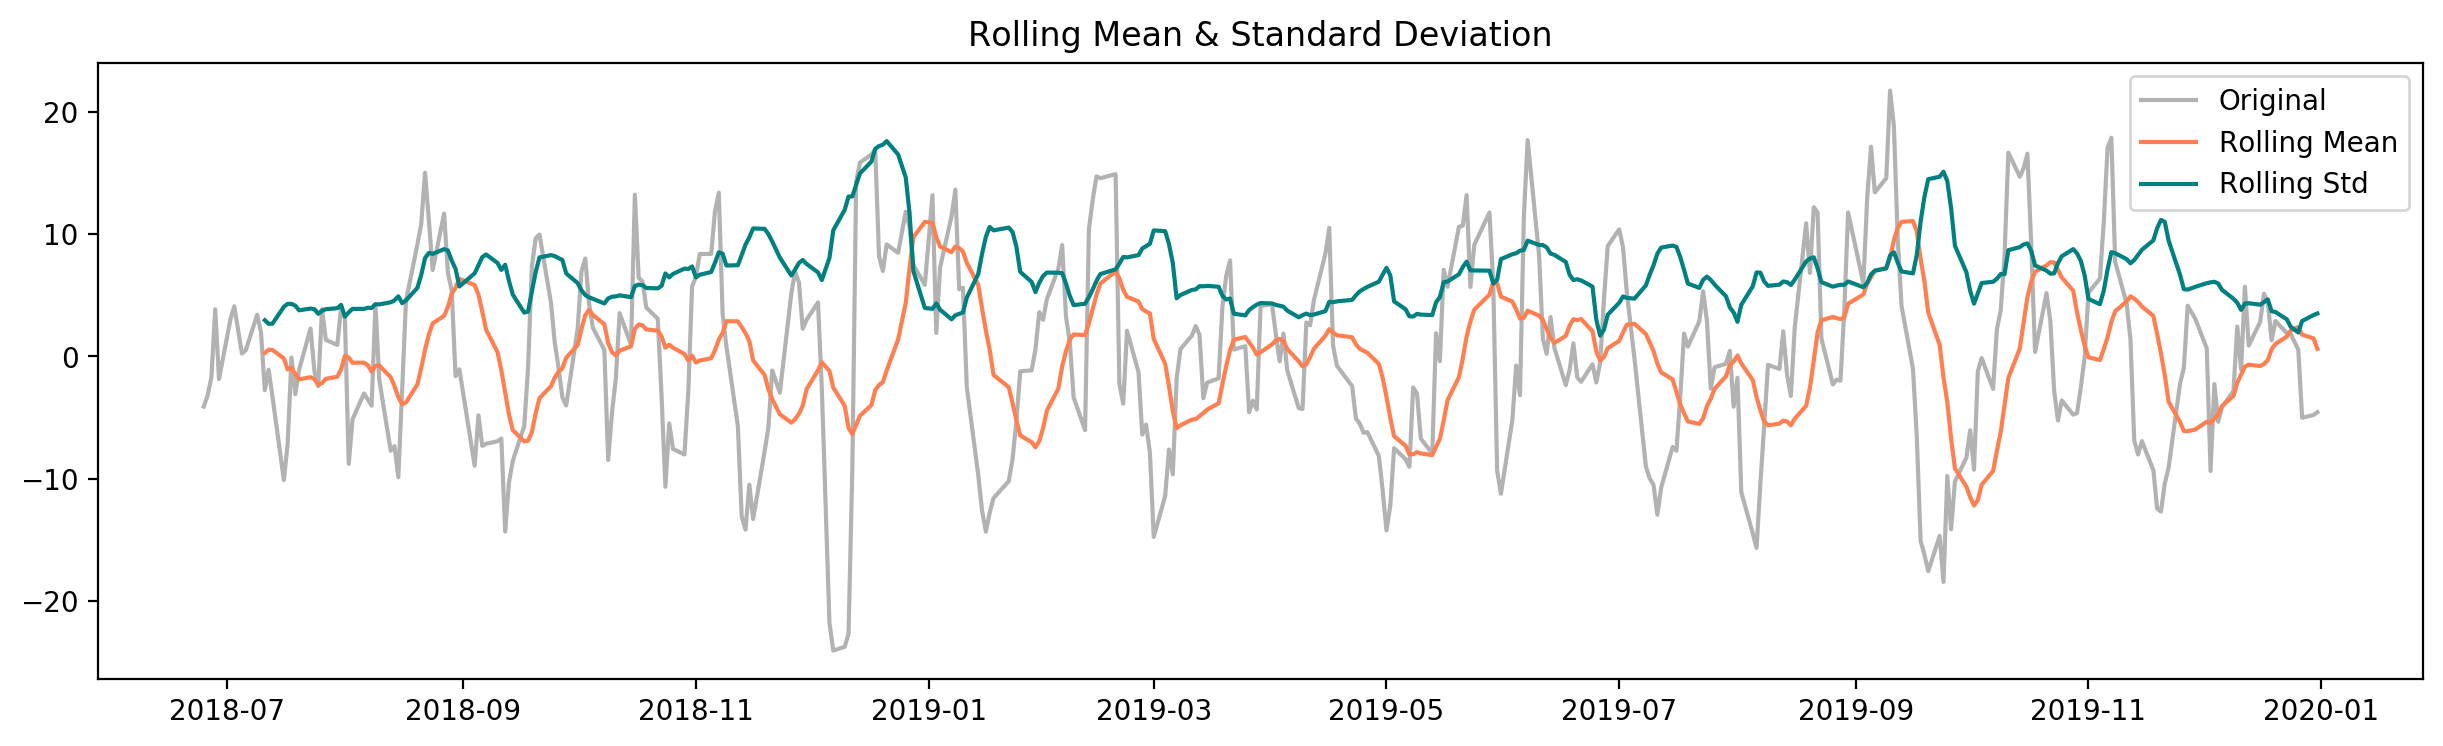

Mean MinMax Delta: 23.290562861545396
Std MinMax Delta: 15.92105425214933
ADF Statistic: -6.8557768007500215
p-value: 1.6499434838558625e-09
Critical Values:
	1%: -3.4483935212959844
	5%: -2.8694912343676497
	10%: -2.571005879151811


In [56]:
# Assess transformed dataset performances
af.get_stationarity(trox_2019_rtn5c_stdev)

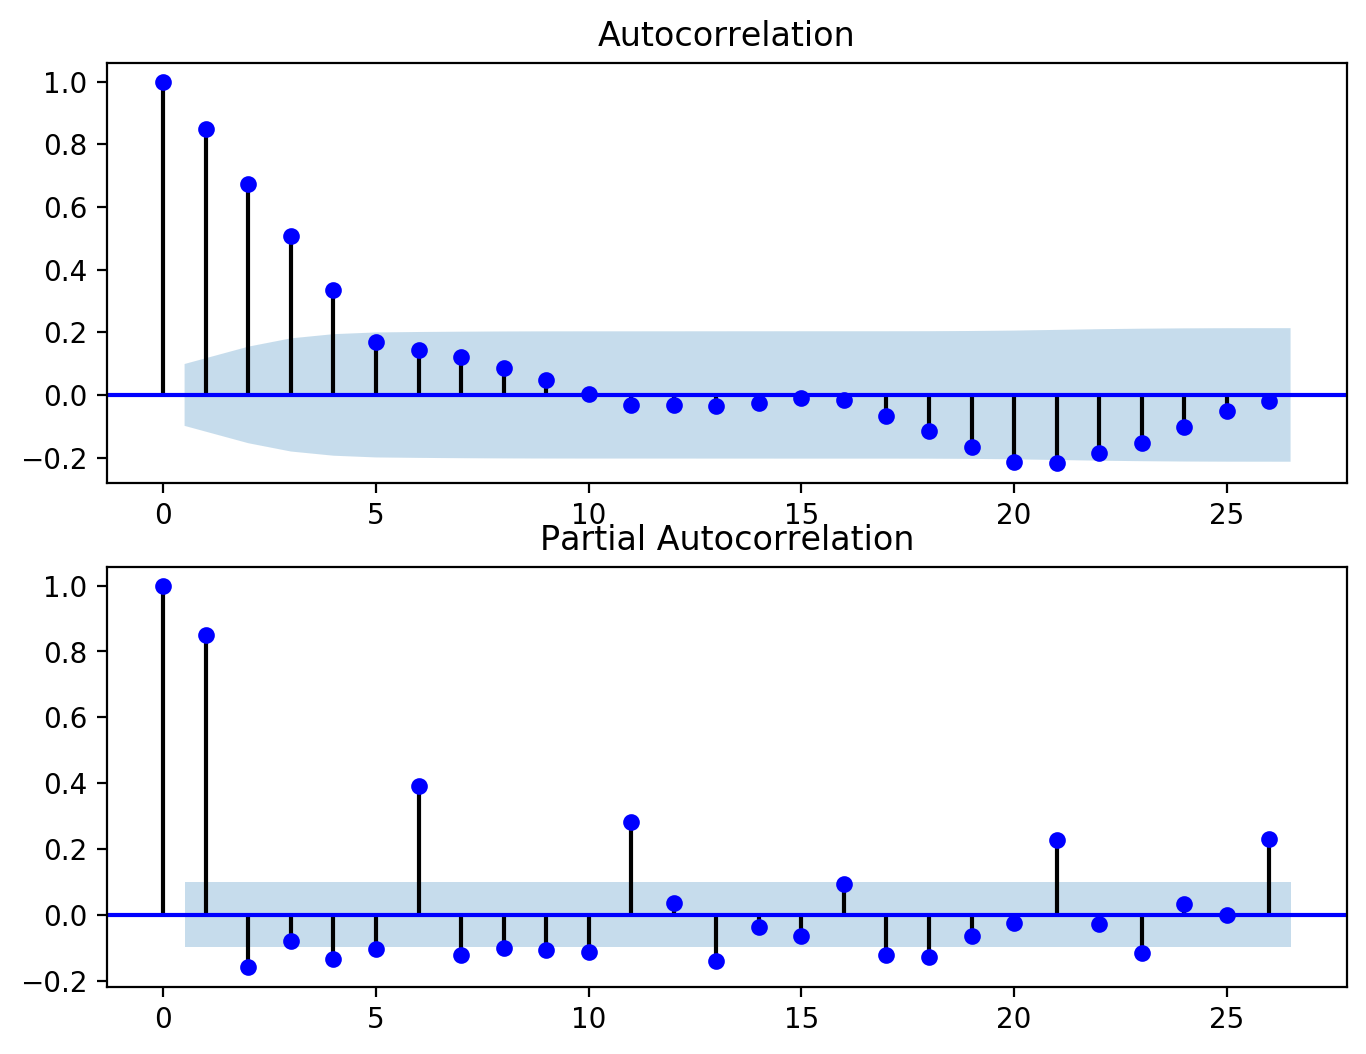

In [57]:
af.plot_corr_function(trox_2019_rtn5c)
plt.show()

In [58]:
# Trouver le paramètre optimal sur une série de paramètre
aic_16_5_var = af.aic_optimize(trox_2019_rtn5c_stdev, ar_max_range= 16, ma_max_range= 8)

The AIC for an ARIMA(0, 0, 0) is:  2689 
The AIC for an ARIMA(0, 0, 1) is:  2434 
The AIC for an ARIMA(0, 0, 2) is:  2295 
The AIC for an ARIMA(0, 0, 3) is:  2295 
The AIC for an ARIMA(0, 0, 4) is:  2083 
The AIC for an ARIMA(0, 0, 5) is:  2085 
The AIC for an ARIMA(0, 0, 6) is:  2086 
The AIC for an ARIMA(0, 0, 7) is:  2087 
The AIC for an ARIMA(1, 0, 0) is:  2270 
The AIC for an ARIMA(1, 0, 1) is:  2259 
The AIC for an ARIMA(1, 0, 2) is:  2258 
The AIC for an ARIMA(1, 0, 3) is:  2222 
The AIC for an ARIMA(1, 0, 4) is:  2085 
The AIC for an ARIMA(1, 0, 5) is:  2070 
The AIC for an ARIMA(1, 0, 6) is:  2070 
The AIC for an ARIMA(1, 0, 7) is:  2086 
The AIC for an ARIMA(2, 0, 0) is:  2255 
The AIC for an ARIMA(2, 0, 1) is:  2228 
The AIC for an ARIMA(2, 0, 2) is:  2226 
The AIC for an ARIMA(2, 0, 3) is:  2187 
The AIC for an ARIMA(2, 0, 4) is:  2086 
The AIC for an ARIMA(2, 0, 5) is:  2070 
The AIC for an ARIMA(2, 0, 6) is:  2072 
The AIC for an ARIMA(2, 0, 7) is:  2072 
The AIC for an A

### Optimal: (2,0,5)
L'AIC optimal est à 2070.
Comme on le retrouve sur plusieurs ordre différence, on peut trancher pour des paramètres optimaux à (2,0,5) pour donner une polynomiale juste assez flexible pour attraper les détails, mais pas trop.

## Validation de performance
### Paramètres de 2019 sur data 2020 en crise

In [59]:
ticker = 'TROX'
yahoo_financials = YahooFinancials(ticker)

data = yahoo_financials.get_historical_price_data(start_date='2020-01-01', 
                                                  end_date='2020-08-25', 
                                                  time_interval='daily')

# Extraire 'price' keys du dict vers un df
trox_2020c = pd.DataFrame(data[ticker]['prices'])

# Remplacer 'formatted_date' col par 'Date'
col = list(trox_2020c.columns) 
col[-1] = 'Date'
trox_2020c.columns = col

# Set index to 'Date'
trox_2020c = trox_2020c.drop('date', axis=1).set_index('Date')

trox_2020c['rtn5'] = trox_2020c['close'].pct_change(5)*100
trox_2020c['rtn5_stdev'], trox_2020c_ravg = af.tfrm_to_MinusMean(trox_2020c['rtn5'])
col_drop = list(trox_2020c.columns[:4])
trox_2020c.drop(columns= col_drop, inplace= True)

trox_2020c.dropna(inplace=True)
trox_2020c.head()

,volume,adjclose,rtn5,rtn5_stdev
Date,,,,
2020-01-27,1851900,9.284901,-11.737519,-9.213962
2020-01-28,1037100,9.265456,-6.200789,-3.198105
2020-01-29,787400,9.177953,-5.600004,-1.713214
2020-01-30,819400,9.041841,-9.268291,-3.586025
2020-01-31,1887200,8.225159,-14.717742,-6.621892


In [60]:
window_size = 85

# Get temporary df of rolling averages
df_roll_temp_c= af.rollwin_ARIMA(trox_2020c['rtn5_stdev'], 
                               actual= 'rtn5_stdev', 
                               ARIMA_order= (2,0,5), 
                               window_size= window_size)

In [61]:
# Stiching all together
df_roll_temp_c['rtn5'] = trox_2020c['rtn5'].iloc[window_size: :]
df_roll_temp_c.columns = ['rtn5_stdev', 'Pred_stdev', 'Erreur', 'rtn5']
# Selon système d'équation résolut sur papier
df_roll_temp_c['Pred_rtn5'] = df_roll_temp_c['rtn5'] - df_roll_temp_c['Erreur']
trox_2020c_pred = df_roll_temp_c.copy()


# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
trox_2020c_pred['Erreur_Dir'] = ((trox_2020c_pred['rtn5'] < 0) 
                                      & (trox_2020c_pred['Pred_rtn5'] > 0)) | ((trox_2020c_pred['rtn5'] > 0) 
                                                                                    & (trox_2020c_pred['Pred_rtn5'] < 0))

In [62]:
trox_2020c_pred['Erreur_Dir'].value_counts(normalize=True)

False    0.870968
True     0.129032
Name: Erreur_Dir, dtype: float64

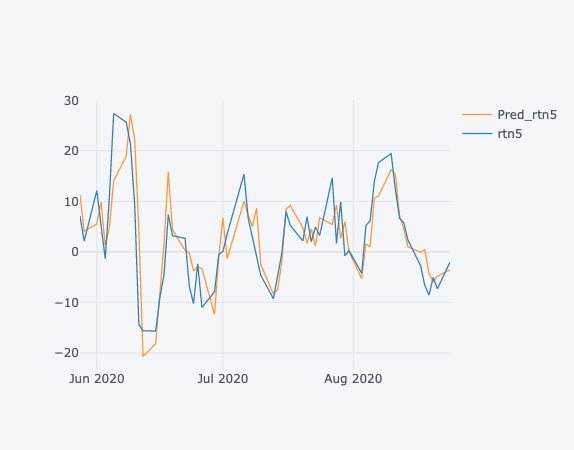

In [63]:
trox_2020c_pred[['Pred_rtn5', 'rtn5']].iplot()

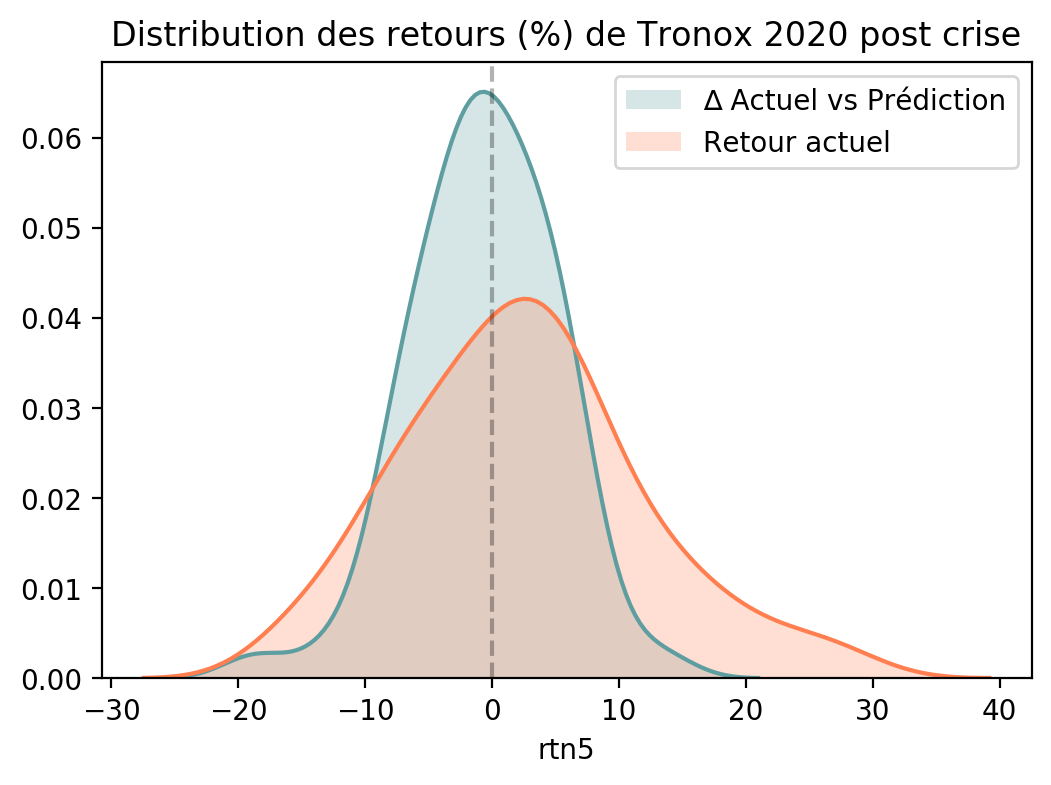

In [64]:
_= fig= plt.figure(figsize= (6, 4))
_= sns.distplot(trox_2020c_pred['Erreur'], hist=False, color="cadetblue", kde_kws={"shade": True})
_= sns.distplot(trox_2020c_pred['rtn5'], hist=False, color="coral", kde_kws={"shade": True})
_= plt.legend(('∆ Actuel vs Prédiction', 'Retour actuel'))
_= plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
_= plt.title('Distribution des retours (%) de Tronox 2020 post crise')
plt.show()

In [65]:
print("Moyenne de l'erreur: {:.3f}% ".format(trox_2020c_pred['Erreur'].mean()))
print("Écart type de l'erreur: {:.3f}%".format(trox_2020c_pred['Erreur'].std()))
print('____________________________')
print("Retour moyen actuel: {:.3f}% ".format(trox_2020c_pred['rtn5'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(trox_2020c_pred['Pred_rtn5'].mean()))
print("Écart type des retours actuels: {:.3f}%".format(trox_2020c_pred['rtn5'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(trox_2020c_pred['Pred_rtn5'].std()))

Moyenne de l'erreur: -0.678% 
Écart type de l'erreur: 5.631%
____________________________
Retour moyen actuel: 2.521% 
Retour moyen prédit: 3.199% 
Écart type des retours actuels: 9.473%
Écart type des retours prédits: 8.627% 


In [47]:
trox_2020c_pred

,rtn5_stdev,Pred_stdev,Erreur,rtn5,Pred_rtn5,Erreur_Dir
Date,,,,,,
2020-05-28,6.444121,10.577832,-4.133711,7.088986,11.222696,False
2020-05-29,1.378438,3.339468,-1.961030,2.153843,4.114872,False
2020-06-01,9.597193,3.510421,6.086772,12.159999,6.073227,False
2020-06-02,2.490123,6.878124,-4.388001,5.381167,9.769168,False
2020-06-03,-5.625142,-3.003953,-2.621189,-1.355013,1.266176,True
...,...,...,...,...,...,...
2020-08-18,-12.372565,-5.478078,-6.894487,-5.898510,0.995976,True
2020-08-19,-13.983027,-9.801676,-4.181351,-7.807642,-3.626291,False
2020-08-20,-9.671158,-10.676123,1.004965,-4.292039,-5.297005,False


### Conclusions
L'erreur de direction sur le "close" est meilleur de 1,5% que sur le "Adj Close". Elle se rapproche d'avantage des autres titres comparables. La magnétude de la prédiction est légèrement améliorée sur le "close", mais la différence n'est pas statistiquement significative.

## Prédiction du close non transformé

In [1]:
from FinForecast import ArimaForecast as af
from FinForecast import Share
from FinForecast import Historical_stock as Hist

import warnings
warnings.filterwarnings('ignore')

In [2]:
ticker = 'TROX'

# Get the data
df = Hist.get_ohlc_as_df(ticker, start_date= '2019-01-01')

# Make stationary
df2 = af.tfrm_ohlc_to_stationarity_df(df)

# Get predictions
df3 = af.arima_tfrmed_pred_df(df2, ARIMA_order= (2,0,5), window_size= 118)

In [5]:
# Get close prices back into the mix
df4 = pd.merge(df3, df[['close']], left_index= True, right_index= True, how='outer')
# 
df4['pred_rtn5_shift'] = df4['Pred_rtn5'].shift(5)

In [6]:
# Get predicted close price
# j5_close = j1_close * (pred_rtn5 + 1)
j5_close = lambda row: row.close * ((row.pred_rtn5_shift/100) + 1)
df4['pred_close'] = df4.apply(j5_close, axis = 1)
df4.dropna(inplace=True)

NameError: name 'df6' is not defined

In [9]:
df4.head()

,rtn5_stdev,Pred_stdev,Erreur,rtn5,Pred_rtn5,close,pred_rtn5_shift,pred_close
Date,,,,,,,,
2019-07-23,5.340727,5.590409,-0.249682,1.896546,2.146228,11.82,-2.510739,11.523230
2019-07-24,2.900798,3.347376,-0.446579,-0.336700,0.109879,11.84,-5.023668,11.245198
2019-07-25,-2.634845,1.108184,-3.743029,-6.011854,-2.268826,11.10,-0.474575,11.047323
2019-07-26,-0.882796,-2.980180,2.097383,-4.142010,-6.239393,11.34,-1.227178,11.200838
2019-07-29,-0.595726,-3.006072,2.410346,-3.384092,-5.794438,11.42,-1.244983,11.277823


In [11]:
_= df4[['close', 'pred_close']].plot()
plt.show()

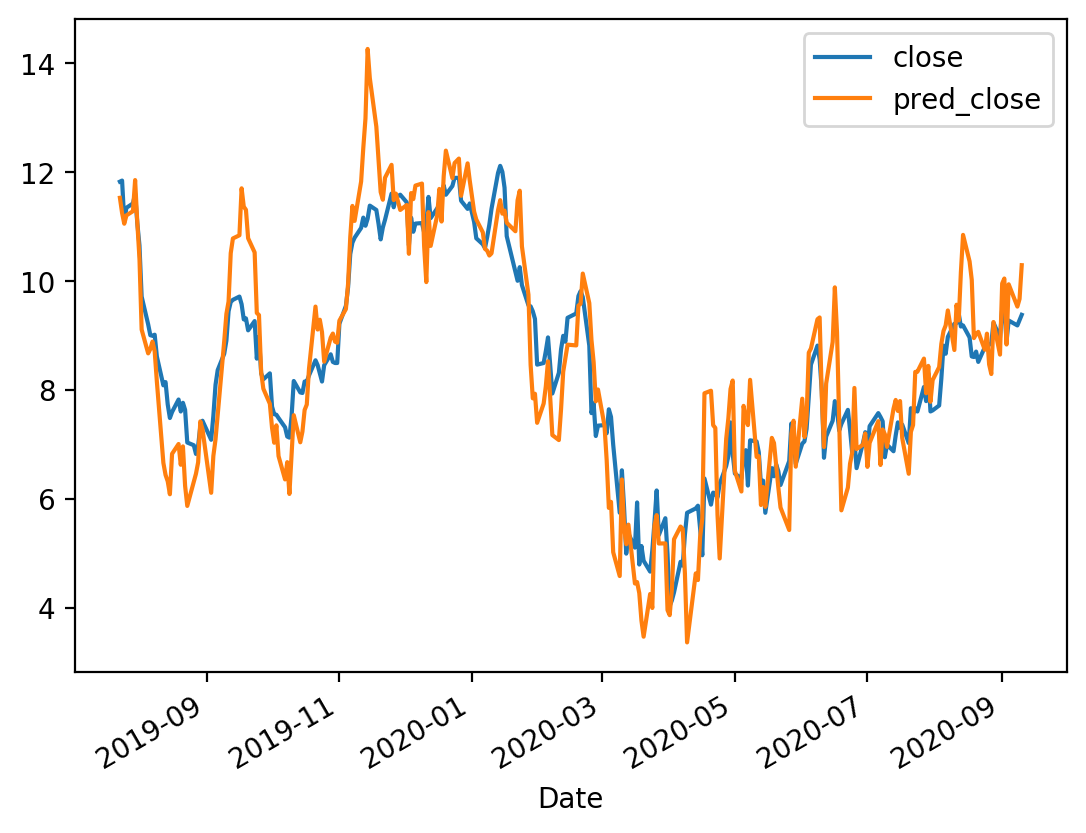

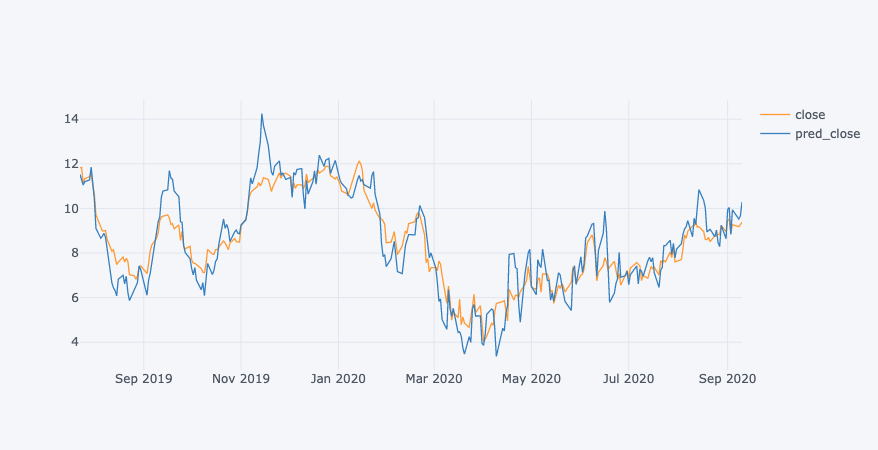

In [15]:
df4[['close', 'pred_close']].iplot()

In [20]:
# Get close prices back into the mix
df4b = pd.merge(df3, df[['close']], left_index= True, right_index= True, how='outer')
df4b.dropna(inplace=True)

In [21]:
df4b.head()

,rtn5_stdev,Pred_stdev,Erreur,rtn5,Pred_rtn5,close
Date,,,,,,
2019-07-16,-7.713473,-4.151337,-3.562135,-6.072874,-2.510739,11.60
2019-07-17,-3.303253,-5.385747,2.082494,-2.941174,-5.023668,11.88
2019-07-18,1.879320,0.291731,1.587589,1.113015,-0.474575,11.81
2019-07-19,0.809039,0.833944,-0.024906,-1.252084,-1.227178,11.83
2019-07-22,2.877291,1.801231,1.076060,-0.168923,-1.244983,11.82


In [23]:
# Get predicted close price
# j5_close = j1_close * (pred_rtn5 + 1)
j5_close = lambda row: row.close * ((row.Pred_rtn5/100) + 1)
df4b['pred_close'] = df4b.apply(j5_close, axis = 1)
df4b['pred_close_shift'] = df4b['pred_close'].shift(5)
df4b.dropna(inplace=True)

In [24]:
df4b.head()

,rtn5_stdev,Pred_stdev,Erreur,rtn5,Pred_rtn5,close,pred_close,pred_close_shift
Date,,,,,,,,
2019-07-23,5.340727,5.590409,-0.249682,1.896546,2.146228,11.82,12.073684,11.308755
2019-07-24,2.900798,3.347376,-0.446579,-0.336700,0.109879,11.84,11.853010,11.283188
2019-07-25,-2.634845,1.108184,-3.743029,-6.011854,-2.268826,11.10,10.848161,11.753953
2019-07-26,-0.882796,-2.980180,2.097383,-4.142010,-6.239393,11.34,10.632453,11.684825
2019-07-29,-0.595726,-3.006072,2.410346,-3.384092,-5.794438,11.42,10.758275,11.672843


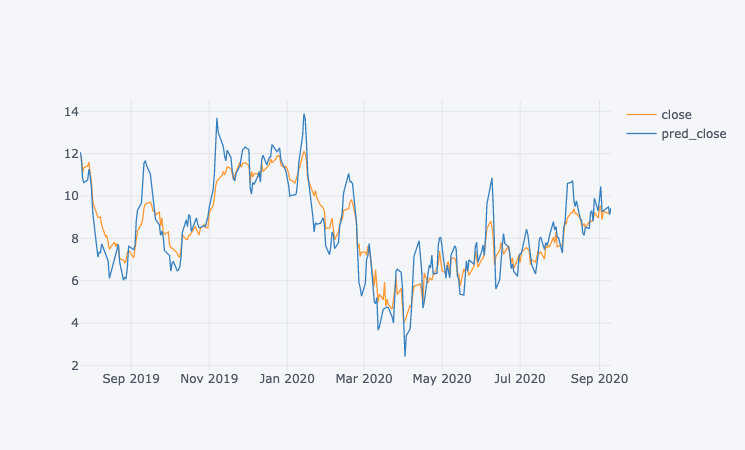

In [170]:
df4b[['close', 'pred_close']].iplot()

## Validation sur pred_emailer script

In [37]:
df_test = pd.read_csv('_Output/TROX_2020_pour_input_arima.csv')
df_test.head()

,Unnamed: 0,close,rtn5,meanDev
0,2020-04-07 00:00:00,4.77,-4.216868,0.498157
1,2020-04-08 00:00:00,5.34,32.506200,33.793421
2,2020-04-09 00:00:00,5.74,38.983041,35.785026
3,2020-04-13 00:00:00,5.82,35.981306,31.141843
4,2020-04-14 00:00:00,5.87,21.280986,16.325027


In [39]:
df_test['rtn5_pandas'] = df_test['close'].pct_change(5)
df_test.tail()

,Unnamed: 0,close,rtn5,meanDev,rtn5_pandas
105,2020-09-04,9.27,0.433379,-1.160019,0.004334
106,2020-09-08,9.18,2.455360,0.238862,0.024554
107,2020-09-09,9.28,-2.109703,-4.758598,-0.021097
108,2020-09-10,9.30,-2.310927,-4.934656,-0.023109
109,2020-09-11,9.24,4.054050,1.247343,0.040541


In [40]:
df_test['rtn5_pandas'] = df_test['rtn5_pandas'] *100

In [41]:
df_test.tail()

,Unnamed: 0,close,rtn5,meanDev,rtn5_pandas
105,2020-09-04,9.27,0.433379,-1.160019,0.433379
106,2020-09-08,9.18,2.455360,0.238862,2.455360
107,2020-09-09,9.28,-2.109703,-4.758598,-2.109703
108,2020-09-10,9.30,-2.310927,-4.934656,-2.310927
109,2020-09-11,9.24,4.054050,1.247343,4.054050


In [44]:
j5_close = lambda row: row.close * ((row.rtn5/100) + 1)
df_test['pred_close'] = df_test.apply(j5_close, axis=1)

j5_close2 = lambda row: row.close + (row.close * (row.rtn5 / 100))
df_test['pred_close2'] = df_test.apply(j5_close2, axis=1)

df_test.tail(10)

,Unnamed: 0,close,rtn5,meanDev,rtn5_pandas,pred_close,pred_close2
100,2020-08-28,9.23,8.460626,9.238798,8.460626,10.010915,10.010915
101,2020-08-31,8.96,2.050117,3.138586,2.050117,9.143691,9.143691
102,2020-09-01,9.48,8.095770,8.704686,8.095770,10.247479,10.247479
103,2020-09-02,9.52,7.814276,7.545798,7.814276,10.263920,10.263920
104,2020-09-03,8.88,0.338980,-0.509084,0.338980,8.910102,8.910102
105,2020-09-04,9.27,0.433379,-1.160019,0.433379,9.310175,9.310175
106,2020-09-08,9.18,2.455360,0.238862,2.455360,9.405402,9.405402
107,2020-09-09,9.28,-2.109703,-4.758598,-2.109703,9.084219,9.084219
108,2020-09-10,9.30,-2.310927,-4.934656,-2.310927,9.085084,9.085084
109,2020-09-11,9.24,4.054050,1.247343,4.054050,9.614594,9.614594


In [43]:
df_test.drop(columns= ['pred_close', 'pred_close2'], inplace=True)

In [66]:
df_test.index = pd.to_datetime(df_test['Unnamed: 0'])
df_test.drop(columns='Unnamed: 0', inplace=True)
df_test.dropna(inplace=True)

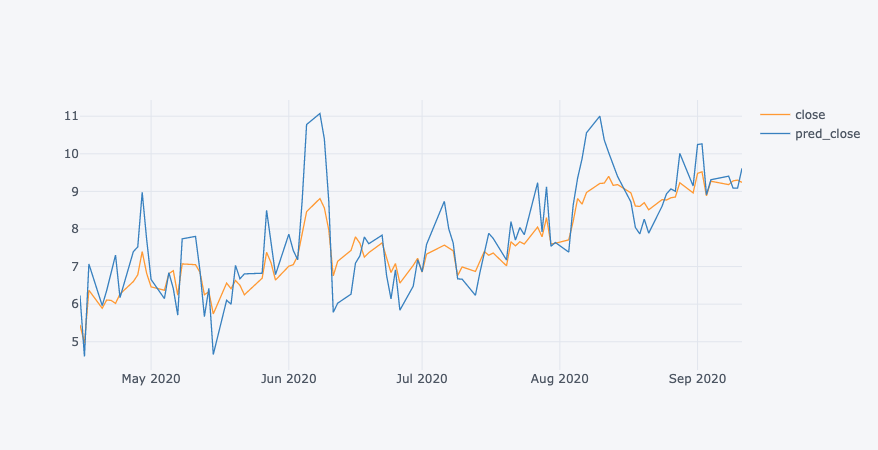

In [67]:
df_test[['close', 'pred_close']].iplot()

In [59]:
# Check si les deux séries sont égales
pd.testing.assert_series_equal(df_test['rtn5'], df_test['rtn5_pandas'], check_less_precise= True, check_names=False)

In [60]:
# Check si les deux séries sont égales
pd.testing.assert_series_equal(df_test['pred_close'], df_test['pred_close2'], check_less_precise= True, check_names=False)

In [83]:
df_test.rename(columns={'meanDev': 'rtn5_stdev'}, inplace= True)
df_test_tfrmed = af.arima_tfrmed_pred_df(df_test, ARIMA_order= (2,0,5), window_size= 92) 

In [84]:
df_test_tfrmed.tail(20)

,rtn5_stdev,Pred_stdev,Erreur,rtn5,Pred_rtn5
Unnamed: 0,,,,,
2020-08-25,0.492150,1.814705,-1.322555,1.858314,3.180868
2020-08-26,2.706653,2.477109,0.229544,2.674413,2.444869
2020-08-27,2.649292,0.849876,1.799416,1.724145,-0.075271
2020-08-28,9.238798,3.954922,5.283876,8.460626,3.176750
2020-08-31,3.138586,4.588316,-1.449730,2.050117,3.499848
2020-09-01,8.704686,3.392417,5.312269,8.095770,2.783501
2020-09-02,7.545798,6.258136,1.287662,7.814276,6.526613
2020-09-03,-0.509084,4.419427,-4.928511,0.338980,5.267491
2020-09-04,-1.160019,-3.825724,2.665706,0.433379,-2.232326


In [72]:
df2.head()

,close,rtn5,rtn5_stdev
Date,,,
2019-01-25,8.96,-0.444444,-1.219210
2019-01-28,8.85,-1.666662,-1.129255
2019-01-29,8.60,-1.376145,0.593342
2019-01-30,8.84,1.028573,3.625817
2019-01-31,8.76,0.343650,3.004235


In [85]:
df_test_tfrmed_ = pd.merge(df_test_tfrmed, df_test[['close']], left_index= True, right_index= True, how='outer')
df_test_tfrmed_.tail(20)

,rtn5_stdev,Pred_stdev,Erreur,rtn5,Pred_rtn5,close
Unnamed: 0,,,,,,
2020-08-14,NaN,NaN,NaN,NaN,NaN,9.18
2020-08-17,NaN,NaN,NaN,NaN,NaN,8.96
2020-08-18,NaN,NaN,NaN,NaN,NaN,8.61
2020-08-19,NaN,NaN,NaN,NaN,NaN,8.60
2020-08-20,NaN,NaN,NaN,NaN,NaN,8.70
2020-08-21,NaN,NaN,NaN,NaN,NaN,8.51
2020-08-24,NaN,NaN,NaN,NaN,NaN,8.78
2020-08-25,0.492150,1.814705,-1.322555,1.858314,3.180868,8.77
2020-08-26,2.706653,2.477109,0.229544,2.674413,2.444869,8.83


In [86]:
j5_close3 = lambda row: row.close * ((row.Pred_rtn5/100) + 1)
df_test_tfrmed_['pred_close'] = df_test_tfrmed_.apply(j5_close3, axis=1)
df_test_tfrmed_.tail(15)

,rtn5_stdev,Pred_stdev,Erreur,rtn5,Pred_rtn5,close,pred_close
Unnamed: 0,,,,,,,
2020-08-21,NaN,NaN,NaN,NaN,NaN,8.51,NaN
2020-08-24,NaN,NaN,NaN,NaN,NaN,8.78,NaN
2020-08-25,0.492150,1.814705,-1.322555,1.858314,3.180868,8.77,9.048963
2020-08-26,2.706653,2.477109,0.229544,2.674413,2.444869,8.83,9.045882
2020-08-27,2.649292,0.849876,1.799416,1.724145,-0.075271,8.85,8.843339
2020-08-28,9.238798,3.954922,5.283876,8.460626,3.176750,9.23,9.523214
2020-08-31,3.138586,4.588316,-1.449730,2.050117,3.499848,8.96,9.273586
2020-09-01,8.704686,3.392417,5.312269,8.095770,2.783501,9.48,9.743875
2020-09-02,7.545798,6.258136,1.287662,7.814276,6.526613,9.52,10.141334


In [88]:
df_test_tfrmed_['pred_shift'] = df_test_tfrmed_['pred_close'].shift(5)
df_test_tfrmed_[['close', 'pred_shift']].tail(10)

,close,pred_shift
Unnamed: 0,,
2020-08-28,9.23,NaN
2020-08-31,8.96,NaN
2020-09-01,9.48,9.048963
2020-09-02,9.52,9.045882
2020-09-03,8.88,8.843339
2020-09-04,9.27,9.523214
2020-09-08,9.18,9.273586
2020-09-09,9.28,9.743875
2020-09-10,9.30,10.141334


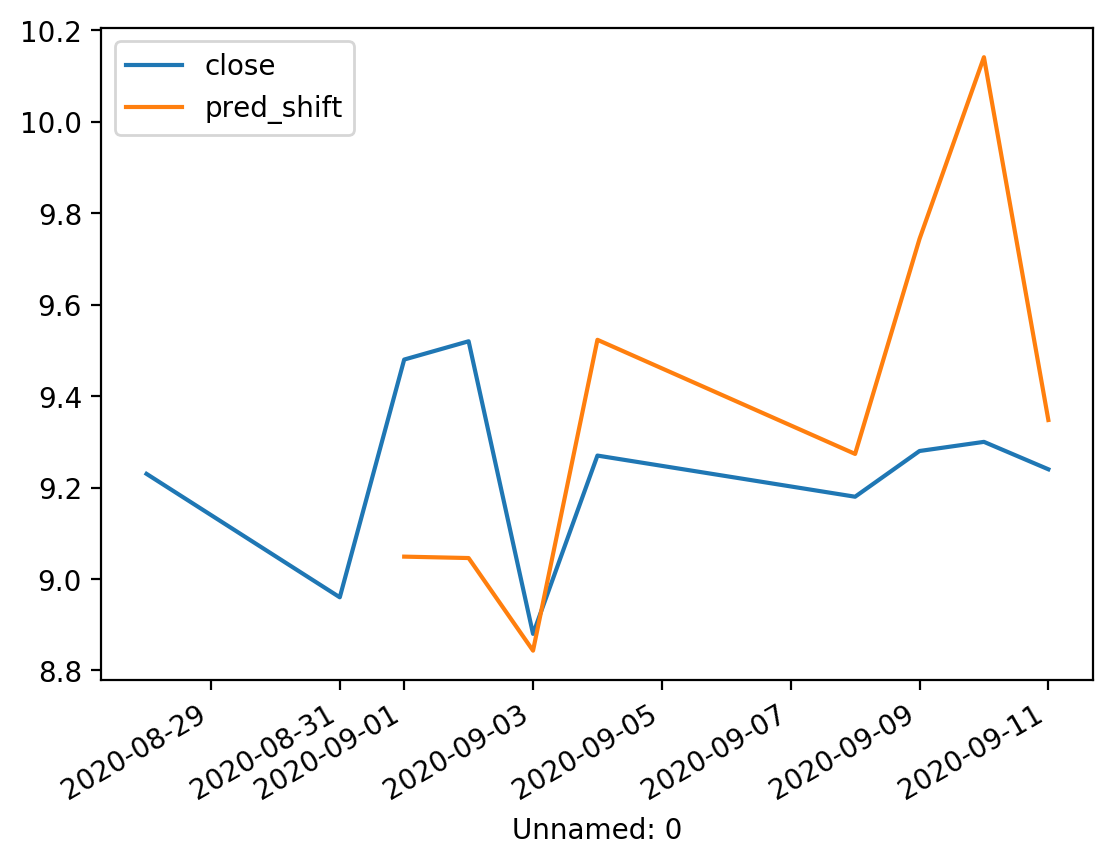

In [95]:
df_test_tfrmed_[['close', 'pred_shift']].tail(10).plot()
plt.show()

In [96]:
df_test_tfrmed_.tail(10)

,rtn5_stdev,Pred_stdev,Erreur,rtn5,Pred_rtn5,close,pred_close,pred_shift
Unnamed: 0,,,,,,,,
2020-08-28,9.238798,3.954922,5.283876,8.460626,3.176750,9.23,9.523214,NaN
2020-08-31,3.138586,4.588316,-1.449730,2.050117,3.499848,8.96,9.273586,NaN
2020-09-01,8.704686,3.392417,5.312269,8.095770,2.783501,9.48,9.743875,9.048963
2020-09-02,7.545798,6.258136,1.287662,7.814276,6.526613,9.52,10.141334,9.045882
2020-09-03,-0.509084,4.419427,-4.928511,0.338980,5.267491,8.88,9.347753,8.843339
2020-09-04,-1.160019,-3.825724,2.665706,0.433379,-2.232326,9.27,9.063064,9.523214
2020-09-08,0.238862,0.729599,-0.490737,2.455360,2.946097,9.18,9.450452,9.273586
2020-09-09,-4.758598,-3.368558,-1.390041,-2.109703,-0.719662,9.28,9.213215,9.743875
2020-09-10,-4.934656,-4.255176,-0.679480,-2.310927,-1.631447,9.30,9.148276,10.141334


In [ ]:
#df_test_reduit = df_test.iloc[:-5, :]
#df_test_reduit.drop(columns= ['rtn5_pandas', 'pred_close', 'pred_close2'], inplace=True)

# Calcul today's return with {lag} days ago
todays_close = df_test_reduit['close'].iloc[-1]
five_days_ago_close = df_test_reduit['close'].iloc[-6]
todays_return5 = ( ( todays_close / five_days_ago_close ) - 1) * 100 
df_test_reduit['rtn5'].iloc[-1] = todays_return5

# Transform (find) today's mean deviation return
todays_transformed_return = todays_return5 - df_test_reduit.iloc[-12:, 1].mean()
df_test_reduit['rtn5_stdev'].iloc[-1] = todays_transformed_return

# Forecast (transformed return format)
transformed_forecast = af.arima_tfrmed_pred_df(df_test_reduit, 
                                               actual='rtn5_stdev', 
                                               ARIMA_order= ARIMA_order, 
                                               window_size= window_size)

# Reverting the transformation to get closing price in 5 days
erreur = todays_transformed_return - transformed_forecast
pred_rtn5 = todays_return5 - erreur
predicted_price_in_five_days = todays_close + (todays_close * (pred_rtn5 / 100))

In [103]:
df_test_reduit = df_test.iloc[:-5, :]
todays_close = df_test_reduit['close'].iloc[-1]
todays_close

8.880000114440918

In [104]:
five_days_ago_close = df_test_reduit['close'].iloc[-6]
five_days_ago_close

8.850000381469727

In [106]:
todays_return5 = ( ( todays_close / five_days_ago_close ) - 1) * 100 
todays_return5

0.33898001896142116

In [107]:
todays_transformed_return = todays_return5 - df_test_reduit.iloc[-12:, 1].mean()
todays_transformed_return

-0.5090840109334803

In [116]:
def arima_forecast(array, ARIMA_order= (1,0,1), window_size= 100 ):

    mod_arma_t = ARIMA(array, order= ARIMA_order)
    res_arma_t = mod_arma_t.fit()

    # Prédire 1 jour au-delà du dataset (One step prediction)
    pred_arma_t = res_arma_t.predict(end= window_size + 1) 
    
    return pred_arma_t

In [117]:
transformed_forecast = arima_forecast(df_test_reduit['rtn5_stdev'], 
                                         ARIMA_order= (2,0,5),
                                         window_size= 92)

In [120]:
df_test_reduit.tail()

,close,rtn5,rtn5_stdev
Unnamed: 0,,,
2020-08-28,9.23,8.460626,9.238798
2020-08-31,8.96,2.050117,3.138586
2020-09-01,9.48,8.095770,8.704686
2020-09-02,9.52,7.814276,7.545798
2020-09-03,8.88,0.338980,-0.509084


In [123]:
transformed_forecast.tail()

Unnamed: 0
2020-08-20   -10.958049
2020-08-21    -8.214251
2020-08-24    -6.050888
2020-08-25     2.194850
2020-08-26     2.924565
dtype: float64

In [124]:
from statsmodels.tsa.arima.model import ARIMA

In [163]:
#array = np.array(df_test_reduit['rtn5_stdev'].iloc[-92:])
mod_arma_t = ARIMA(df_test_reduit['rtn5_stdev'].iloc[-92:], order= (2,0,5))

In [164]:
res_arma_t = mod_arma_t.fit()

In [165]:
pred_arma_t = res_arma_t.predict(end= len(array) + 1)

In [169]:
pred_arma_t[92]

-3.8257243474825104

In [141]:
len(df_test_reduit['rtn5_stdev'].iloc[-92:])

92

In [171]:
who

ARIMA	 ARMA	 Hist	 InteractiveShell	 InvestStrat	 Share	 YahooFinancials	 adfuller	 af	 
arima_forecast	 array	 ass_test	 cf	 df	 df2	 df3	 df3b	 df4	 
df4b	 df_test	 df_test_reduit	 df_test_tfrmed	 df_test_tfrmed_	 five_days_ago_close	 init_notebook_mode	 iplot	 j5_close	 
j5_close2	 j5_close3	 mod_arma_t	 np	 pd	 plot_acf	 plot_pacf	 plt	 pred_arma_t	 
res_arma_t	 sns	 ticker	 todays_close	 todays_return5	 todays_transformed_return	 transformed_forecast	 warnings	 


In [172]:
dtest = df.to_records()
type(dtest)

numpy.recarray

In [174]:
type(tuple(dtest))

tuple